### Deep Learning - Mini Project 1
Faiz Ganz

In [1]:
import numpy as np
import torch
from torch import nn
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

#### Using GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Model Class

In [3]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):

        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1,
                          stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [3, 5, 3])

#### Model Instantiation

In [4]:
model = project1_model().cuda()

#### Model Summary

In [5]:
summary(model, (3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─Conv2d: 3-3                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-4             [-1, 64, 32, 32]          128
|    |    └─Sequential: 3-5              [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-7             [-1, 64, 32, 32]          128
|    |    └─Conv2d: 3-8                  [-1, 64, 32, 32]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─Conv2d: 3-3                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-4             [-1, 64, 32, 32]          128
|    |    └─Sequential: 3-5              [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-7             [-1, 64, 32, 32]          128
|    |    └─Conv2d: 3-8                  [-1, 64, 32, 32]         

Number of Trainable Parameters

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model))

4918602


#### Data with Augmentation



In [7]:
standard_transform = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
                                         ])

# Just Horizontal Flip
augment_transform1 = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                         transforms.RandomHorizontalFlip(p=1.0),
                                         ])

# Zoom-out
augment_transform2 = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomCrop(32, padding=4)
                                         ])



# Zoom-in
augment_transform3 = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.Resize(size=(36, 36)),
                                         transforms.RandomCrop(32)
                                         ])

# Rotation
augment_transform4 = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomRotation(90),
                                         ])

# Color Jitter
augment_transform5 = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                         transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                         transforms.RandomHorizontalFlip(),
                                         ])




standardtrainingdata = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=True,transform=standard_transform)
augmentedtrainingdata1 = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=False,transform=augment_transform1)
augmentedtrainingdata2 = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=False,transform=augment_transform2)
augmentedtrainingdata3 = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=False,transform=augment_transform3)
augmentedtrainingdata4 = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=False,transform=augment_transform4)
augmentedtrainingdata5 = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=False,transform=augment_transform5)
# augmentedtrainingdata6 = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=False,transform=augment_transform6)

trainingdata = torch.utils.data.ConcatDataset([standardtrainingdata,
                                               augmentedtrainingdata1,
                                               augmentedtrainingdata2,
                                               augmentedtrainingdata3,
                                               augmentedtrainingdata4,
                                               augmentedtrainingdata5,
                                              #  augmentedtrainingdata6,
                                               ])
testdata = torchvision.datasets.CIFAR10('./CIFAR10/',train=False,download=False,transform=standard_transform)

trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=32,shuffle=True, num_workers=2, pin_memory=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified


#### Loss Metric and Optimizer (Cross Entropy and SGD)

In [8]:
import torch.optim as optim

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
lr = 0.1
momentum = 0.9
milestones = [15,25,35,45]
gamma = 0.1
weight_decay = 0.0001

optimizer = optim.SGD(
                      model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay,
                      )
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)

In [9]:
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

EPOCHS = 50

best_accuracy = 0.0

for epoch in range(EPOCHS):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        _, predictions = torch.max(output, 1)
        fit = criterion(output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        train_acc += torch.sum(predictions == labels.data)
    scheduler.step()

    model.eval()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
            _, predictions = torch.max(output, 1)
            fit = criterion(output,labels)
            test_loss += fit.item()
            test_acc += torch.sum(predictions == labels.data)

    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc = (train_acc.float() / len(trainDataLoader.dataset)).item()
    test_acc = (test_acc.float() / len(testDataLoader.dataset)).item()

    train_acc_history += [train_acc]
    test_acc_history += [test_acc]
    print('Epoch %s, Train Loss: %s, Test loss %s, Test acc %s'%(epoch, np.round(train_loss, 5), np.round(test_loss, 5), np.round(test_acc, 5)))

    if (test_acc >= 0.94) and (test_acc > best_accuracy):
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'res.pt')
        print("Model Saved... Accuracy = " + str(test_acc))

Epoch 0, Train Loss: 1.31016, Test loss 0.65194, Test acc 0.7735
Epoch 1, Train Loss: 0.72435, Test loss 0.60359, Test acc 0.797
Epoch 2, Train Loss: 0.61797, Test loss 0.45038, Test acc 0.8493
Epoch 3, Train Loss: 0.57188, Test loss 0.45223, Test acc 0.8472
Epoch 4, Train Loss: 0.54522, Test loss 0.42265, Test acc 0.856
Epoch 5, Train Loss: 0.52769, Test loss 0.39305, Test acc 0.8671
Epoch 6, Train Loss: 0.5162, Test loss 0.38161, Test acc 0.873
Epoch 7, Train Loss: 0.50687, Test loss 0.39373, Test acc 0.8703
Epoch 8, Train Loss: 0.49828, Test loss 0.39382, Test acc 0.8623
Epoch 9, Train Loss: 0.49179, Test loss 0.42162, Test acc 0.8599
Epoch 10, Train Loss: 0.486, Test loss 0.36408, Test acc 0.8796
Epoch 11, Train Loss: 0.48453, Test loss 0.34469, Test acc 0.8827
Epoch 12, Train Loss: 0.48048, Test loss 0.37031, Test acc 0.8769
Epoch 13, Train Loss: 0.47863, Test loss 0.39189, Test acc 0.8726
Epoch 14, Train Loss: 0.47579, Test loss 0.33445, Test acc 0.8864
Epoch 15, Train Loss: 0.24

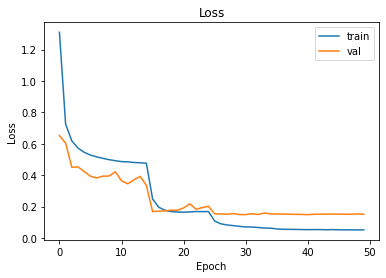

In [24]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(["train", "val"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('loss.png', dpi=1200)

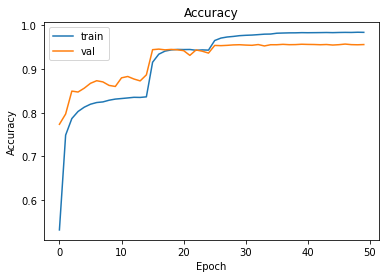

In [25]:
plt.plot(train_acc_history)
plt.plot(test_acc_history)
plt.legend(["train", "val"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig('acc.png', dpi=1200)